# BiLSTM Text Classification - IMDB Sentiment

**Group 9 - Text Classification Project**  
**Dataset:** IMDB Movie Reviews (Sentiment Classification)  
**Model:** Bidirectional LSTM (BiLSTM)

## Objectives
1. Implement BiLSTM with **three embedding approaches**: TF-IDF, GloVe, Word2Vec (Skip-gram)
2. Train and tune each model with the same preprocessing strategy
3. Evaluate and compare performance with confusion matrices, ROC curves, and metrics
4. Generate comparison visualizations for the report

## Embedding-Model Combinations
| Embedding | Input representation | Use case |
|-----------|---------------------|----------|
| **TF-IDF** | Document vector (1 timestep) | Sparse bag-of-words style |
| **GloVe** | Sequence of pre-trained word vectors | Dense, pre-trained |
| **Word2Vec** | Sequence of custom-trained word vectors | Dense, domain-specific |

## 1. Imports and configuration

In [29]:
# Install missing dependencies if needed (run once)
%pip install -q gensim nltk

2613.35s - pydevd: Sending message related to process being replaced timed-out after 5 seconds



[notice] A new release of pip is available: 25.0.1 -> 26.0.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [30]:
# Data and numerical
import pandas as pd
import numpy as np
import re
import json
import time
import os
import shutil
import sys
import warnings
from pathlib import Path

# Scikit-learn
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, classification_report, roc_curve, auc
)

# TensorFlow / Keras
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (
    Dense, Bidirectional, LSTM, Embedding, Dropout, Masking
)
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.utils import set_random_seed

# Word embeddings
from gensim.models import Word2Vec

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# NLTK (stopwords)
import nltk
try:
    nltk.data.find('corpora/stopwords')
except LookupError:
    nltk.download('stopwords')
from nltk.corpus import stopwords

warnings.filterwarnings('ignore')
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (10, 6)

# Reproducibility
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
set_random_seed(RANDOM_SEED)

print(f"TensorFlow version: {tf.__version__}")
print("All imports successful.")

TensorFlow version: 2.20.0
All imports successful.


In [31]:
# Paths (notebook is in notebooks/)
NOTEBOOK_DIR = Path.cwd()
PROJECT_ROOT = NOTEBOOK_DIR.parent
DATA_RAW = PROJECT_ROOT / "data" / "raw" / "IMDB Dataset.csv"
GLOVE_PATH = PROJECT_ROOT / "data" / "embeddings" / "glove.6B.100d.txt"
RESULTS_DIR = PROJECT_ROOT / "results" / "member2_bilstm"
FIGURES_DIR = PROJECT_ROOT / "figures" / "results"
FIGURES_BILSTM = PROJECT_ROOT / "figures" / "bilstm"

RESULTS_DIR.mkdir(parents=True, exist_ok=True)
FIGURES_DIR.mkdir(parents=True, exist_ok=True)
FIGURES_BILSTM.mkdir(parents=True, exist_ok=True)

# Model constants
MAXLEN = 300          # max words per review (sequence length)
EMBED_DIM = 100       # GloVe/Word2Vec dimension
LSTM_UNITS = 64
BATCH_SIZE = 64
EPOCHS = 15
TFIDF_MAX_FEATURES = 5000

STOP_WORDS = set(stopwords.words('english'))
print(f"Data path: {DATA_RAW}")
print(f"Results: {RESULTS_DIR}")
print(f"Figures: {FIGURES_DIR}")

Data path: /Users/sagemuhodari/Documents/LUA/machin Learning technique/Group_9_Text_classification/data/raw/IMDB Dataset.csv
Results: /Users/sagemuhodari/Documents/LUA/machin Learning technique/Group_9_Text_classification/results/member2_bilstm
Figures: /Users/sagemuhodari/Documents/LUA/machin Learning technique/Group_9_Text_classification/figures/results


## 2. Load data and preprocessing

Same strategy as the rest of the project: lowercase, remove HTML/URLs, keep letters; stopwords removed for TF-IDF, kept for GloVe/Word2Vec.

In [32]:
def preprocess_text(text, remove_stopwords=False):
    text = str(text).lower()
    text = re.sub(r'<[^>]+>', '', text)
    text = re.sub(r'http\S+|www\S+', '', text)
    text = re.sub(r'[^a-z\s]', ' ', text)
    text = re.sub(r'\s+', ' ', text).strip()
    if remove_stopwords:
        tokens = [w for w in text.split() if w not in STOP_WORDS and len(w) > 2]
        text = ' '.join(tokens)
    return text

# Load dataset
df = pd.read_csv(DATA_RAW)
df['label'] = df['sentiment'].map({'negative': 0, 'positive': 1})
df['review_clean'] = df['review'].apply(lambda x: preprocess_text(x, remove_stopwords=False))
print(f"Loaded {len(df)} reviews. Columns: {df.columns.tolist()}")
df[['review_clean', 'sentiment', 'label']].head()

Loaded 50000 reviews. Columns: ['review', 'sentiment', 'label', 'review_clean']


,review_clean,sentiment,label
0,one of the other reviewers has mentioned that ...,positive,1
1,a wonderful little production the filming tech...,positive,1
2,i thought this was a wonderful way to spend ti...,positive,1
3,basically there s a family where a little boy ...,negative,0
4,petter mattei s love in the time of money is a...,positive,1


## 2.5 figures/bilstm (model-generated only)

All figures in `figures/bilstm/` are **generated from the BiLSTM model** (training history, confusion matrices, ROC curves, comparison charts). They are saved there when you run the model sections below.

In [33]:
# figures/bilstm is populated by model-generated figures (saved in sections 4, 5, 6, 7 below)
print("BiLSTM model figures will be saved to:", FIGURES_BILSTM)

BiLSTM model figures will be saved to: /Users/sagemuhodari/Documents/LUA/machin Learning technique/Group_9_Text_classification/figures/bilstm


In [34]:
# Train / validation / test split (70 / 10 / 20)
X = df['review_clean'].values
y = df['label'].values
X_temp, X_test, y_temp, y_test = train_test_split(
    X, y, test_size=0.2, random_state=RANDOM_SEED, stratify=y
)
val_ratio = 0.1 / 0.8
X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=val_ratio, random_state=RANDOM_SEED, stratify=y_temp
)
print(f"Train: {len(X_train)}, Val: {len(X_val)}, Test: {len(X_test)}")
print(f"Class balance - Train: {np.bincount(y_train)}, Test: {np.bincount(y_test)}")

Train: 35000, Val: 5000, Test: 10000
Class balance - Train: [17500 17500], Test: [5000 5000]


## 3. Evaluation helpers

Reusable functions for metrics and plots.

In [35]:
def evaluate(y_true, y_pred, y_prob=None):
    metrics = {
        'accuracy': accuracy_score(y_true, y_pred),
        'precision': precision_score(y_true, y_pred, average='binary', zero_division=0),
        'recall': recall_score(y_true, y_pred, average='binary', zero_division=0),
        'f1_score': f1_score(y_true, y_pred, average='binary', zero_division=0),
    }
    if y_prob is not None:
        fpr, tpr, _ = roc_curve(y_true, y_prob)
        metrics['roc_auc'] = auc(fpr, tpr)
    return metrics

def plot_confusion_matrix(y_true, y_pred, title, save_path=None):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=True,
                xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
    plt.title(title, fontsize=14, fontweight='bold')
    plt.ylabel('True Label'); plt.xlabel('Predicted Label')
    plt.tight_layout()
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()

def plot_roc(y_true, y_prob, title, save_path=None):
    fpr, tpr, _ = roc_curve(y_true, y_prob)
    roc_auc = auc(fpr, tpr)
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC (AUC = {roc_auc:.4f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0]); plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate'); plt.ylabel('True Positive Rate')
    plt.title(title, fontsize=14, fontweight='bold')
    plt.legend(loc='lower right'); plt.grid(alpha=0.3); plt.tight_layout()
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()

def plot_training_history(history, title, save_path=None):
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    axes[0].plot(history.history['accuracy'], label='Train'); axes[0].plot(history.history['val_accuracy'], label='Val')
    axes[0].set_title('Accuracy'); axes[0].set_xlabel('Epoch'); axes[0].legend(); axes[0].grid(alpha=0.3)
    axes[1].plot(history.history['loss'], label='Train'); axes[1].plot(history.history['val_loss'], label='Val')
    axes[1].set_title('Loss'); axes[1].set_xlabel('Epoch'); axes[1].legend(); axes[1].grid(alpha=0.3)
    plt.suptitle(title, fontsize=14, fontweight='bold')
    plt.tight_layout()
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()

print("Evaluation helpers defined.")

Evaluation helpers defined.


## 4. BiLSTM + TF-IDF

TF-IDF gives one vector per document. We reshape to `(n_samples, 1, n_features)` so the BiLSTM sees one timestep per document.

In [36]:
# TF-IDF for documents (stopwords removed for better sparse features)
X_train_tfidf_clean = np.array([preprocess_text(t, remove_stopwords=True) for t in X_train])
X_val_tfidf_clean = np.array([preprocess_text(t, remove_stopwords=True) for t in X_val])
X_test_tfidf_clean = np.array([preprocess_text(t, remove_stopwords=True) for t in X_test])

tfidf = TfidfVectorizer(max_features=TFIDF_MAX_FEATURES, ngram_range=(1, 2), min_df=5, max_df=0.8, sublinear_tf=True)
X_train_tfidf = tfidf.fit_transform(X_train_tfidf_clean).toarray()
X_val_tfidf = tfidf.transform(X_val_tfidf_clean).toarray()
X_test_tfidf = tfidf.transform(X_test_tfidf_clean).toarray()

# Reshape for LSTM: (samples, timesteps=1, features)
n_features = X_train_tfidf.shape[1]
X_train_seq = X_train_tfidf.reshape(-1, 1, n_features)
X_val_seq = X_val_tfidf.reshape(-1, 1, n_features)
X_test_seq = X_test_tfidf.reshape(-1, 1, n_features)
print(f"TF-IDF shape: train {X_train_seq.shape}, test {X_test_seq.shape}")

TF-IDF shape: train (35000, 1, 5000), test (10000, 1, 5000)


In [37]:
# BiLSTM for TF-IDF (1 timestep, n_features per step)
model_tfidf = Sequential([
    Bidirectional(LSTM(LSTM_UNITS, return_sequences=False, dropout=0.2),
                  input_shape=(1, n_features)),
    Dense(32, activation='relu'),
    Dropout(0.3),
    Dense(1, activation='sigmoid')
])
model_tfidf.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model_tfidf.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ bidirectional_3 (Bidirectional) │ (None, 128)            │     2,593,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 32)             │         4,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,597,441 (9.91 MB)

 Trainable params: 2,597,441 (9.91 MB)

 Non-trainable params: 0 (0.00 B)

In [38]:
callbacks = [
    EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True, verbose=1),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, min_lr=1e-6, verbose=1)
]
start = time.time()
history_tfidf = model_tfidf.fit(
    X_train_seq, y_train,
    validation_data=(X_val_seq, y_val),
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    callbacks=callbacks,
    verbose=1
)
train_time_tfidf = time.time() - start
print(f"Training time: {train_time_tfidf:.2f}s")

Epoch 1/15
547/547 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.8519 - loss: 0.3494 - val_accuracy: 0.8910 - val_loss: 0.2606 - learning_rate: 0.0010
Epoch 2/15
547/547 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.9010 - loss: 0.2505 - val_accuracy: 0.8894 - val_loss: 0.2610 - learning_rate: 0.0010
Epoch 3/15
543/547 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9056 - loss: 0.2383
Epoch 3: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
547/547 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.9080 - loss: 0.2324 - val_accuracy: 0.8858 - val_loss: 0.2656 - learning_rate: 0.0010
Epoch 4/15
547/547 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.9161 - loss: 0.2032 - val_accuracy: 0.8860 - val_loss: 0.2745 - learning_rate: 5.0000e-04
Epoch 4: early stopping
Restoring model weights from the end of the best epoch: 1.
Training time: 14.66s


313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 671us/step
BiLSTM + TF-IDF - Test metrics: {'accuracy': 0.8944, 'precision': 0.8877310263468344, 'recall': 0.903, 'f1_score': 0.8953004164187983, 'roc_auc': 0.9605794399999998, 'training_time': 14.656466007232666}


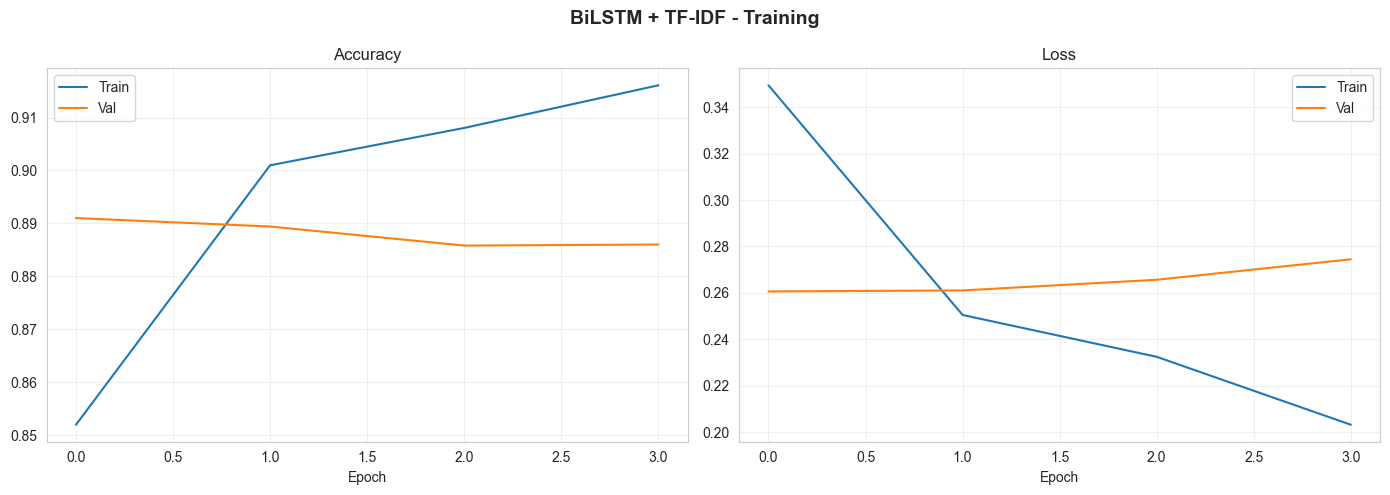

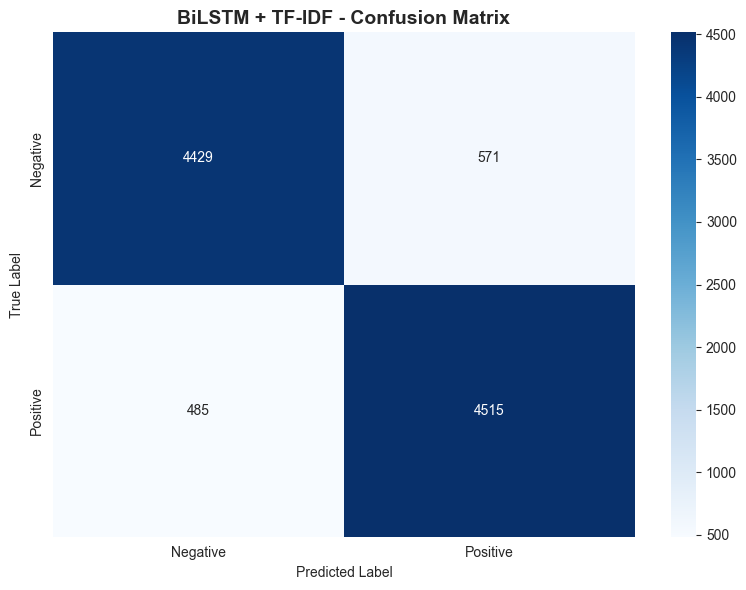

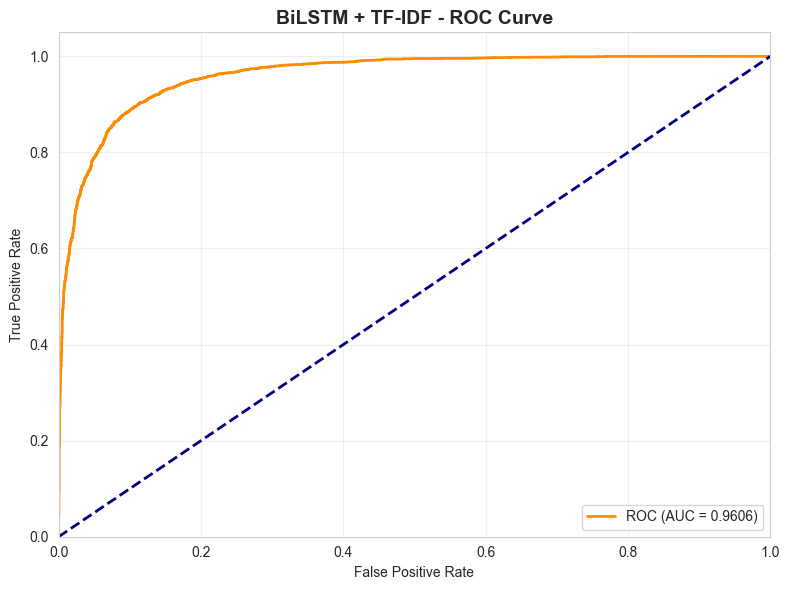

Saved to figures/bilstm: [PosixPath('/Users/sagemuhodari/Documents/LUA/machin Learning technique/Group_9_Text_classification/figures/bilstm/bilstm_tfidf_history.png'), PosixPath('/Users/sagemuhodari/Documents/LUA/machin Learning technique/Group_9_Text_classification/figures/bilstm/confusion_matrix_bilstm_tfidf.png'), PosixPath('/Users/sagemuhodari/Documents/LUA/machin Learning technique/Group_9_Text_classification/figures/bilstm/roc_curve_bilstm_tfidf.png')]


In [39]:
# Evaluate BiLSTM + TF-IDF
y_pred_tfidf = (model_tfidf.predict(X_test_seq).flatten() > 0.5).astype(int)
y_prob_tfidf = model_tfidf.predict(X_test_seq).flatten()
metrics_tfidf = evaluate(y_test, y_pred_tfidf, y_prob_tfidf)
metrics_tfidf['training_time'] = train_time_tfidf
print("BiLSTM + TF-IDF - Test metrics:", metrics_tfidf)
plot_training_history(history_tfidf, "BiLSTM + TF-IDF - Training", save_path=str(FIGURES_DIR / "bilstm_tfidf_history.png"))
plot_confusion_matrix(y_test, y_pred_tfidf, "BiLSTM + TF-IDF - Confusion Matrix",
                      save_path=str(FIGURES_DIR / "confusion_matrix_bilstm_tfidf.png"))
plot_roc(y_test, y_prob_tfidf, "BiLSTM + TF-IDF - ROC Curve",
         save_path=str(FIGURES_DIR / "roc_curve_bilstm_tfidf.png"))
for f in ["bilstm_tfidf_history.png", "confusion_matrix_bilstm_tfidf.png", "roc_curve_bilstm_tfidf.png"]:
    shutil.copy(FIGURES_DIR / f, FIGURES_BILSTM / f)
print("Saved to figures/bilstm:", list(FIGURES_BILSTM.glob("*tfidf*")))

## 5. BiLSTM + GloVe

Tokenize reviews into word sequences, pad to fixed length, and use pre-trained GloVe embeddings in an Embedding layer.

In [40]:
# Tokenizer (fit on train only)
tokenizer = Tokenizer(oov_token='<OOV>', num_words=None)
tokenizer.fit_on_texts(X_train)
X_train_seq_glove = tokenizer.texts_to_sequences(X_train)
X_val_seq_glove = tokenizer.texts_to_sequences(X_val)
X_test_seq_glove = tokenizer.texts_to_sequences(X_test)
X_train_pad = pad_sequences(X_train_seq_glove, maxlen=MAXLEN, padding='post', truncating='post')
X_val_pad = pad_sequences(X_val_seq_glove, maxlen=MAXLEN, padding='post', truncating='post')
X_test_pad = pad_sequences(X_test_seq_glove, maxlen=MAXLEN, padding='post', truncating='post')
vocab_size = len(tokenizer.word_index) + 1
print(f"Vocabulary size: {vocab_size}, Padded shape: {X_train_pad.shape}")

Vocabulary size: 87086, Padded shape: (35000, 300)


In [41]:
# Load GloVe
embeddings_index = {}
with open(GLOVE_PATH, 'r', encoding='utf-8') as f:
    for line in f:
        values = line.split()
        word = values[0]
        try:
            coefs = np.asarray(values[1:], dtype='float32')
            embeddings_index[word] = coefs
        except (ValueError, IndexError):
            continue
embed_dim_glove = len(next(iter(embeddings_index.values())))
print(f"Loaded {len(embeddings_index):,} GloVe vectors, dim={embed_dim_glove}")

# Build embedding matrix
embedding_matrix_glove = np.zeros((vocab_size, embed_dim_glove))
for word, i in tokenizer.word_index.items():
    if i >= vocab_size:
        continue
    if word in embeddings_index:
        embedding_matrix_glove[i] = embeddings_index[word]
print(f"Embedding matrix shape: {embedding_matrix_glove.shape}")

Loaded 400,000 GloVe vectors, dim=100
Embedding matrix shape: (87086, 100)


In [42]:
# BiLSTM + GloVe
model_glove = Sequential([
    Embedding(vocab_size, embed_dim_glove, weights=[embedding_matrix_glove],
              input_length=MAXLEN, trainable=False),
    Masking(mask_value=0.0),
    Bidirectional(LSTM(LSTM_UNITS, return_sequences=False, dropout=0.2)),
    Dense(32, activation='relu'),
    Dropout(0.3),
    Dense(1, activation='sigmoid')
])
model_glove.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model_glove.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_2 (Embedding)         │ ?                      │     8,708,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ masking_2 (Masking)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_4 (Bidirectional) │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,708,600 (33.22 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 8,708,600 (33.22 MB)

In [43]:
start = time.time()
history_glove = model_glove.fit(
    X_train_pad, y_train,
    validation_data=(X_val_pad, y_val),
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    callbacks=callbacks,
    verbose=1
)
train_time_glove = time.time() - start
print(f"Training time: {train_time_glove:.2f}s")

Epoch 1/15
547/547 ━━━━━━━━━━━━━━━━━━━━ 36s 62ms/step - accuracy: 0.6662 - loss: 0.6110 - val_accuracy: 0.7900 - val_loss: 0.4660 - learning_rate: 0.0010
Epoch 2/15
547/547 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - accuracy: 0.7757 - loss: 0.4902
Epoch 2: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
547/547 ━━━━━━━━━━━━━━━━━━━━ 35s 63ms/step - accuracy: 0.7920 - loss: 0.4613 - val_accuracy: 0.8340 - val_loss: 0.3790 - learning_rate: 0.0010
Epoch 3/15
547/547 ━━━━━━━━━━━━━━━━━━━━ 36s 66ms/step - accuracy: 0.8237 - loss: 0.4029 - val_accuracy: 0.8452 - val_loss: 0.3604 - learning_rate: 5.0000e-04
Epoch 3: early stopping
Restoring model weights from the end of the best epoch: 1.
Training time: 107.07s


313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step
BiLSTM + GloVe - Test metrics: {'accuracy': 0.7924, 'precision': 0.7931034482758621, 'recall': 0.7912, 'f1_score': 0.7921505806968362, 'roc_auc': 0.86072836, 'training_time': 107.07359075546265}


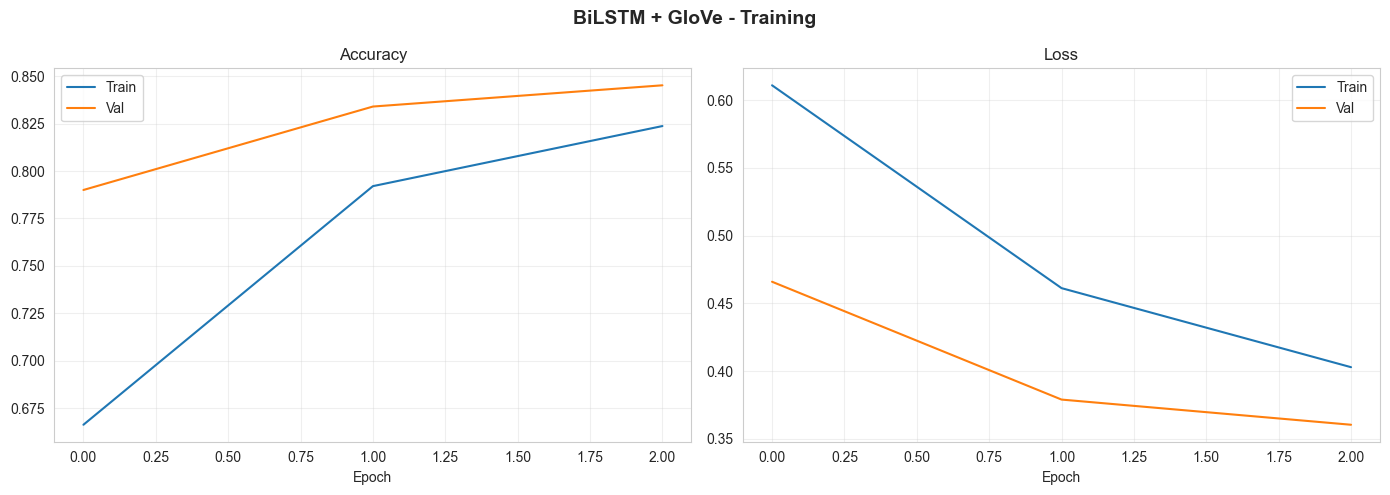

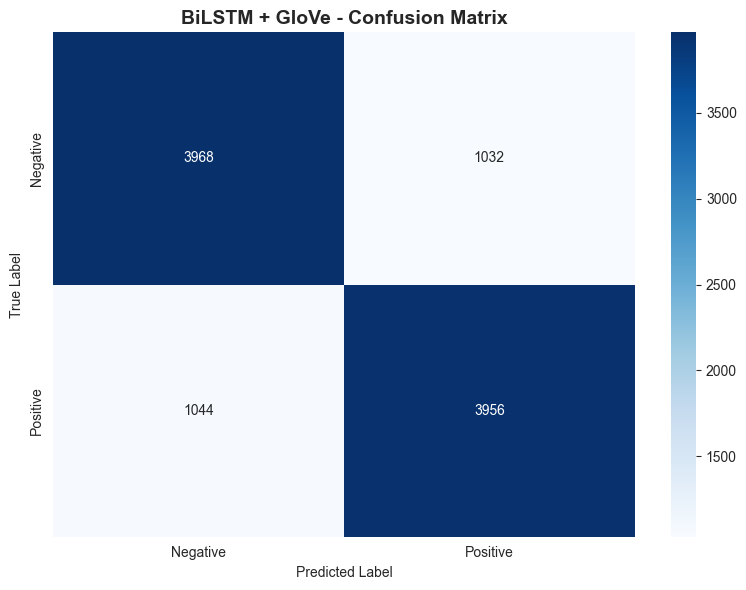

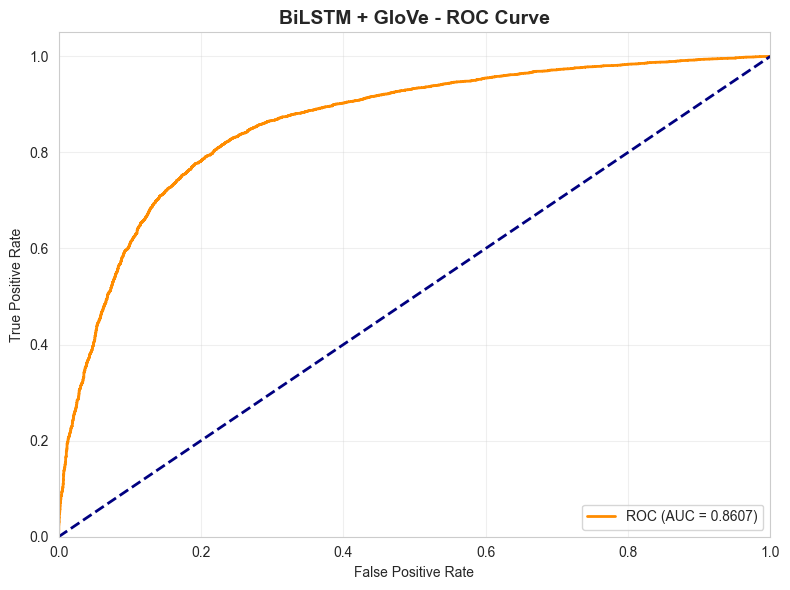

Saved to figures/bilstm: [PosixPath('/Users/sagemuhodari/Documents/LUA/machin Learning technique/Group_9_Text_classification/figures/bilstm/roc_curve_bilstm_glove.png'), PosixPath('/Users/sagemuhodari/Documents/LUA/machin Learning technique/Group_9_Text_classification/figures/bilstm/bilstm_glove_history.png'), PosixPath('/Users/sagemuhodari/Documents/LUA/machin Learning technique/Group_9_Text_classification/figures/bilstm/confusion_matrix_bilstm_glove.png')]


In [44]:
# Evaluate BiLSTM + GloVe
y_pred_glove = (model_glove.predict(X_test_pad).flatten() > 0.5).astype(int)
y_prob_glove = model_glove.predict(X_test_pad).flatten()
metrics_glove = evaluate(y_test, y_pred_glove, y_prob_glove)
metrics_glove['training_time'] = train_time_glove
print("BiLSTM + GloVe - Test metrics:", metrics_glove)
plot_training_history(history_glove, "BiLSTM + GloVe - Training", save_path=str(FIGURES_DIR / "bilstm_glove_history.png"))
plot_confusion_matrix(y_test, y_pred_glove, "BiLSTM + GloVe - Confusion Matrix",
                     save_path=str(FIGURES_DIR / "confusion_matrix_bilstm_glove.png"))
plot_roc(y_test, y_prob_glove, "BiLSTM + GloVe - ROC Curve",
         save_path=str(FIGURES_DIR / "roc_curve_bilstm_glove.png"))
for f in ["bilstm_glove_history.png", "confusion_matrix_bilstm_glove.png", "roc_curve_bilstm_glove.png"]:
    shutil.copy(FIGURES_DIR / f, FIGURES_BILSTM / f)
print("Saved to figures/bilstm:", list(FIGURES_BILSTM.glob("*glove*")))

## 6. BiLSTM + Word2Vec (Skip-gram)

Train Word2Vec on the training corpus, then build an embedding matrix for the same tokenizer and use it in BiLSTM.

In [45]:
# Train Word2Vec on training texts (same tokenization: list of word lists)
sentences_w2v = [text.split() for text in X_train]
w2v_model = Word2Vec(sentences=sentences_w2v, vector_size=EMBED_DIM, window=5, min_count=2, workers=4, sg=1, seed=RANDOM_SEED, epochs=10)
print(f"Word2Vec vocabulary size: {len(w2v_model.wv)}")

# Embedding matrix from Word2Vec (align with tokenizer)
embedding_matrix_w2v = np.zeros((vocab_size, EMBED_DIM))
for word, i in tokenizer.word_index.items():
    if i >= vocab_size:
        continue
    if word in w2v_model.wv:
        embedding_matrix_w2v[i] = w2v_model.wv[word]
print(f"Embedding matrix shape: {embedding_matrix_w2v.shape}")

Exception ignored in: 'gensim.models.word2vec_inner.our_dot_float'
Exception ignored in: 'gensim.models.word2vec_inner.our_dot_float'
Exception ignored in: 'gensim.models.word2vec_inner.our_dot_float'
Exception ignored in: 'gensim.models.word2vec_inner.our_dot_float'
Exception ignored in: 'gensim.models.word2vec_inner.our_dot_float'
Exception ignored in: 'gensim.models.word2vec_inner.our_dot_float'
Exception ignored in: 'gensim.models.word2vec_inner.our_dot_float'
Exception ignored in: 'gensim.models.word2vec_inner.our_dot_float'
Exception ignored in: 'gensim.models.word2vec_inner.our_dot_float'
Exception ignored in: 'gensim.models.word2vec_inner.our_dot_float'
Exception ignored in: 'gensim.models.word2vec_inner.our_dot_float'
Exception ignored in: 'gensim.models.word2vec_inner.our_dot_float'
Exception ignored in: 'gensim.models.word2vec_inner.our_dot_float'
Exception ignored in: 'gensim.models.word2vec_inner.our_dot_float'
Exception ignored in: 'gensim.models.word2vec_inner.our_dot_fl

Word2Vec vocabulary size: 54089
Embedding matrix shape: (87086, 100)


In [46]:
# BiLSTM + Word2Vec (same padding as GloVe: X_train_pad, X_val_pad, X_test_pad)
model_w2v = Sequential([
    Embedding(vocab_size, EMBED_DIM, weights=[embedding_matrix_w2v],
              input_length=MAXLEN, trainable=False),
    Masking(mask_value=0.0),
    Bidirectional(LSTM(LSTM_UNITS, return_sequences=False, dropout=0.2)),
    Dense(32, activation='relu'),
    Dropout(0.3),
    Dense(1, activation='sigmoid')
])
model_w2v.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model_w2v.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_3 (Embedding)         │ ?                      │     8,708,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ masking_3 (Masking)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_5 (Bidirectional) │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,708,600 (33.22 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 8,708,600 (33.22 MB)

In [47]:
start = time.time()
history_w2v = model_w2v.fit(
    X_train_pad, y_train,
    validation_data=(X_val_pad, y_val),
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    callbacks=callbacks,
    verbose=1
)
train_time_w2v = time.time() - start
print(f"Training time: {train_time_w2v:.2f}s")

Epoch 1/15
547/547 ━━━━━━━━━━━━━━━━━━━━ 37s 64ms/step - accuracy: 0.7510 - loss: 0.5040 - val_accuracy: 0.8332 - val_loss: 0.3954 - learning_rate: 0.0010
Epoch 2/15
547/547 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 0.8039 - loss: 0.4264
Epoch 2: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
547/547 ━━━━━━━━━━━━━━━━━━━━ 34s 61ms/step - accuracy: 0.8094 - loss: 0.4178 - val_accuracy: 0.7240 - val_loss: 0.5237 - learning_rate: 0.0010
Epoch 3/15
547/547 ━━━━━━━━━━━━━━━━━━━━ 34s 62ms/step - accuracy: 0.8338 - loss: 0.3803 - val_accuracy: 0.8710 - val_loss: 0.3069 - learning_rate: 5.0000e-04
Epoch 3: early stopping
Restoring model weights from the end of the best epoch: 1.
Training time: 104.57s


313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step
BiLSTM + Word2Vec - Test metrics: {'accuracy': 0.8311, 'precision': 0.8993968636911942, 'recall': 0.7456, 'f1_score': 0.8153089119737561, 'roc_auc': 0.9219168399999998, 'training_time': 104.56729912757874}


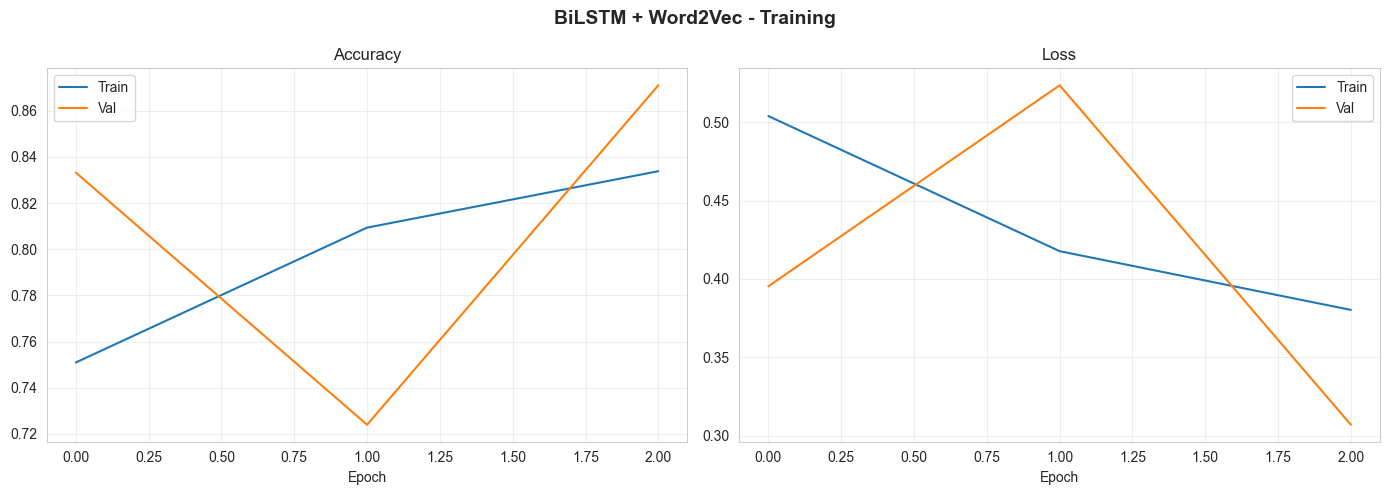

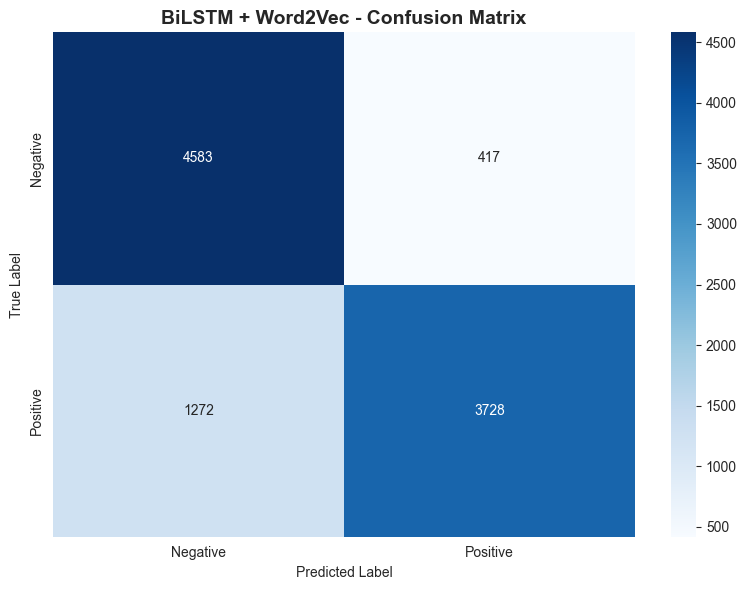

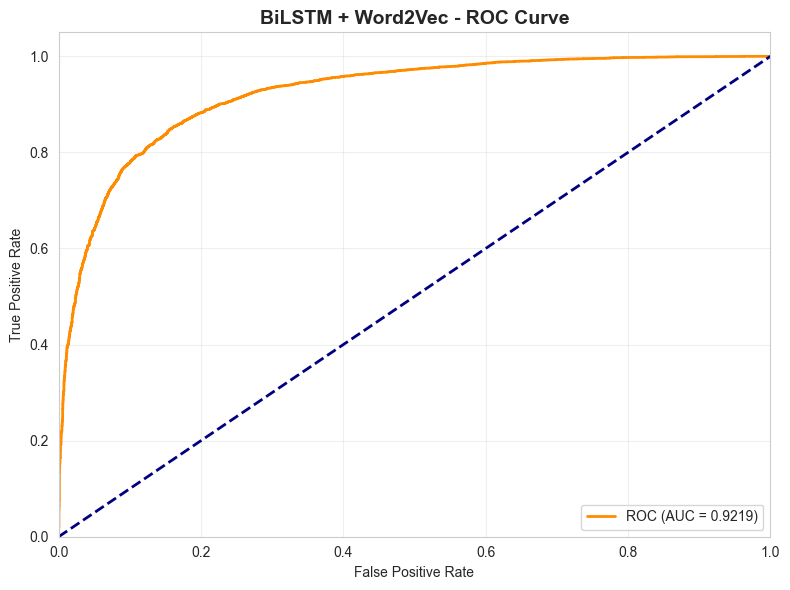

Saved to figures/bilstm: [PosixPath('/Users/sagemuhodari/Documents/LUA/machin Learning technique/Group_9_Text_classification/figures/bilstm/confusion_matrix_bilstm_word2vec.png'), PosixPath('/Users/sagemuhodari/Documents/LUA/machin Learning technique/Group_9_Text_classification/figures/bilstm/bilstm_word2vec_history.png'), PosixPath('/Users/sagemuhodari/Documents/LUA/machin Learning technique/Group_9_Text_classification/figures/bilstm/roc_curve_bilstm_word2vec.png')]


In [48]:
# Evaluate BiLSTM + Word2Vec
y_pred_w2v = (model_w2v.predict(X_test_pad).flatten() > 0.5).astype(int)
y_prob_w2v = model_w2v.predict(X_test_pad).flatten()
metrics_w2v = evaluate(y_test, y_pred_w2v, y_prob_w2v)
metrics_w2v['training_time'] = train_time_w2v
print("BiLSTM + Word2Vec - Test metrics:", metrics_w2v)
plot_training_history(history_w2v, "BiLSTM + Word2Vec - Training", save_path=str(FIGURES_DIR / "bilstm_word2vec_history.png"))
plot_confusion_matrix(y_test, y_pred_w2v, "BiLSTM + Word2Vec - Confusion Matrix",
                     save_path=str(FIGURES_DIR / "confusion_matrix_bilstm_word2vec.png"))
plot_roc(y_test, y_prob_w2v, "BiLSTM + Word2Vec - ROC Curve",
         save_path=str(FIGURES_DIR / "roc_curve_bilstm_word2vec.png"))
for f in ["bilstm_word2vec_history.png", "confusion_matrix_bilstm_word2vec.png", "roc_curve_bilstm_word2vec.png"]:
    shutil.copy(FIGURES_DIR / f, FIGURES_BILSTM / f)
print("Saved to figures/bilstm:", list(FIGURES_BILSTM.glob("*word2vec*")))

## 7. Comparative analysis and saved results

Comparison table, bar chart across embeddings, and save metrics to JSON for the report.

In [49]:
# Comparison table
results_bilstm = {
    'BiLSTM+TF-IDF': metrics_tfidf,
    'BiLSTM+GloVe': metrics_glove,
    'BiLSTM+Word2Vec': metrics_w2v
}
comparison = pd.DataFrame([
    {
        'Embedding': name.replace('BiLSTM+', ''),
        'Accuracy': f"{m['accuracy']:.4f}",
        'Precision': f"{m['precision']:.4f}",
        'Recall': f"{m['recall']:.4f}",
        'F1-Score': f"{m['f1_score']:.4f}",
        'ROC-AUC': f"{m.get('roc_auc', 0):.4f}",
        'Training Time (s)': f"{m.get('training_time', 0):.2f}"
    }
    for name, m in results_bilstm.items()
])
print("BiLSTM - Comparison across embeddings")
print(comparison.to_string(index=False))
comparison.to_csv(RESULTS_DIR / "comparison_table_bilstm.csv", index=False)
print(f"\nSaved: {RESULTS_DIR / 'comparison_table_bilstm.csv'}")

BiLSTM - Comparison across embeddings
Embedding Accuracy Precision Recall F1-Score ROC-AUC Training Time (s)
   TF-IDF   0.8944    0.8877 0.9030   0.8953  0.9606             14.66
    GloVe   0.7924    0.7931 0.7912   0.7922  0.8607            107.07
 Word2Vec   0.8311    0.8994 0.7456   0.8153  0.9219            104.57

Saved: /Users/sagemuhodari/Documents/LUA/machin Learning technique/Group_9_Text_classification/results/member2_bilstm/comparison_table_bilstm.csv


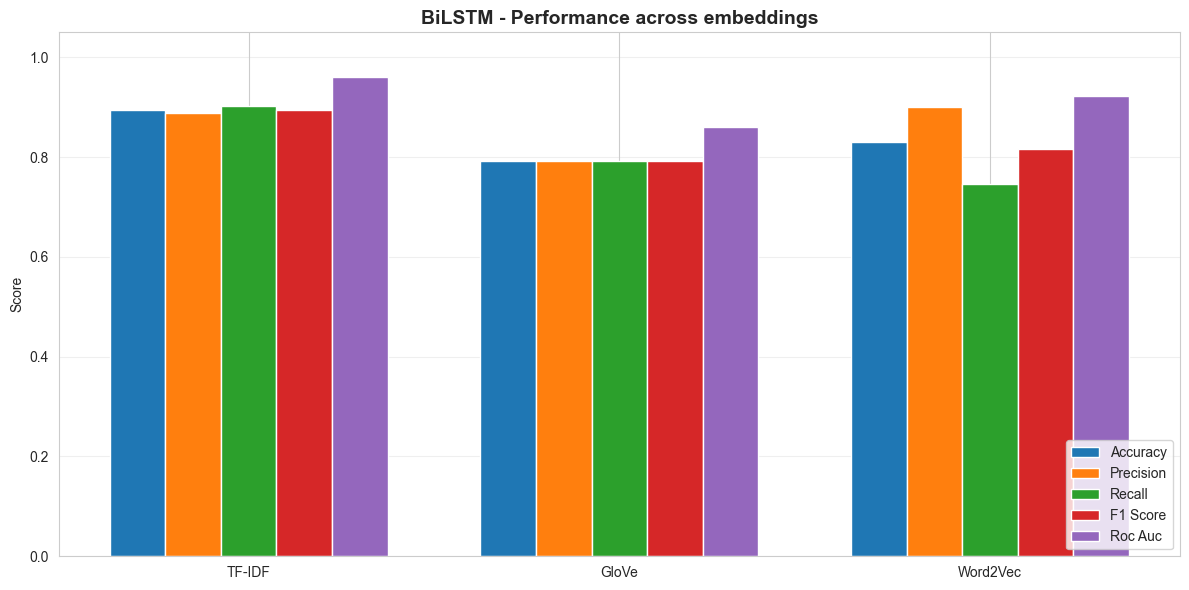

Saved: /Users/sagemuhodari/Documents/LUA/machin Learning technique/Group_9_Text_classification/figures/results/bilstm_all_metrics_comparison.png
Also in figures/bilstm: /Users/sagemuhodari/Documents/LUA/machin Learning technique/Group_9_Text_classification/figures/bilstm/bilstm_all_metrics_comparison.png


In [50]:
# Bar chart: all metrics comparison
metric_names = ['accuracy', 'precision', 'recall', 'f1_score', 'roc_auc']
embeddings = list(results_bilstm.keys())
x = np.arange(len(embeddings))
width = 0.15
fig, ax = plt.subplots(figsize=(12, 6))
for i, metric in enumerate(metric_names):
    values = [results_bilstm[e].get(metric, 0) for e in embeddings]
    ax.bar(x + i * width, values, width, label=metric.replace('_', ' ').title())
ax.set_ylabel('Score'); ax.set_ylim(0, 1.05)
ax.set_xticks(x + width * 2); ax.set_xticklabels([e.replace('BiLSTM+', '') for e in embeddings])
ax.set_title('BiLSTM - Performance across embeddings', fontsize=14, fontweight='bold')
ax.legend(loc='lower right'); ax.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.savefig(FIGURES_DIR / "bilstm_all_metrics_comparison.png", dpi=300, bbox_inches='tight')
plt.show()
shutil.copy(FIGURES_DIR / "bilstm_all_metrics_comparison.png", FIGURES_BILSTM / "bilstm_all_metrics_comparison.png")
print(f"Saved: {FIGURES_DIR / 'bilstm_all_metrics_comparison.png'}")
print(f"Also in figures/bilstm: {FIGURES_BILSTM / 'bilstm_all_metrics_comparison.png'}")

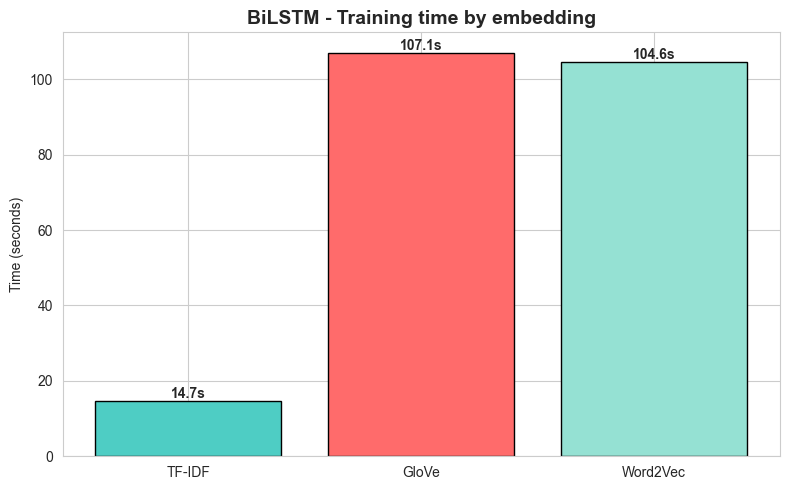

figures/bilstm now has: ['bilstm_all_metrics_comparison.png', 'bilstm_glove_history.png', 'bilstm_tfidf_history.png', 'bilstm_training_time_comparison.png', 'bilstm_word2vec_history.png', 'confusion_matrix_bilstm_glove.png', 'confusion_matrix_bilstm_tfidf.png', 'confusion_matrix_bilstm_word2vec.png', 'roc_curve_bilstm_glove.png', 'roc_curve_bilstm_tfidf.png', 'roc_curve_bilstm_word2vec.png']


In [51]:
# Training time comparison
fig, ax = plt.subplots(figsize=(8, 5))
times = [results_bilstm[e].get('training_time', 0) for e in embeddings]
bars = ax.bar([e.replace('BiLSTM+', '') for e in embeddings], times, color=['#4ecdc4', '#ff6b6b', '#95e1d3'], edgecolor='black')
ax.set_ylabel('Time (seconds)'); ax.set_title('BiLSTM - Training time by embedding', fontsize=14, fontweight='bold')
for b in bars:
    ax.text(b.get_x() + b.get_width()/2, b.get_height(), f'{b.get_height():.1f}s', ha='center', va='bottom', fontweight='bold')
plt.tight_layout()
plt.savefig(FIGURES_DIR / "bilstm_training_time_comparison.png", dpi=300, bbox_inches='tight')
plt.show()
shutil.copy(FIGURES_DIR / "bilstm_training_time_comparison.png", FIGURES_BILSTM / "bilstm_training_time_comparison.png")
print(f"figures/bilstm now has: {sorted(p.name for p in FIGURES_BILSTM.glob('*.png'))}")

In [52]:
# Save results to JSON (for report and compare_results scripts)
for name, m in results_bilstm.items():
    out = {
        'metrics': {k: float(v) if isinstance(v, (np.floating, np.integer)) else v for k, v in m.items()},
        'model': 'BiLSTM',
        'embedding': name.replace('BiLSTM+', ''),
        'timestamp': time.strftime('%Y-%m-%d %H:%M:%S')
    }
    fname = RESULTS_DIR / f"results_bilstm_{name.split('+')[1].lower()}.json"
    with open(fname, 'w') as f:
        json.dump(out, f, indent=4)
    print(f"Saved: {fname}")

Saved: /Users/sagemuhodari/Documents/LUA/machin Learning technique/Group_9_Text_classification/results/member2_bilstm/results_bilstm_tf-idf.json
Saved: /Users/sagemuhodari/Documents/LUA/machin Learning technique/Group_9_Text_classification/results/member2_bilstm/results_bilstm_glove.json
Saved: /Users/sagemuhodari/Documents/LUA/machin Learning technique/Group_9_Text_classification/results/member2_bilstm/results_bilstm_word2vec.json


## Summary

This notebook implemented **BiLSTM** with three embeddings (TF-IDF, GloVe, Word2Vec) on the IMDB sentiment dataset. Outputs include:

- **Figures:** Confusion matrices, ROC curves, and training history for each embedding; comparison bar charts in `figures/results/`
- **Results:** JSON metrics and comparison CSV in `results/member2_bilstm/`

You can use these results in the group report and compare with Logistic Regression (member1) and other sequence models.